## Project : Aerodynamics |  Thin Airfoil Theory

#### -  Aim : To apply the concepts of thin airfiol theory to predict aerodynamic parameters and analyize for the inaccuracies and limits of this theory. 

In [17]:
# Import Statements
import time, copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import quad 


#### Objective 1 : To create a class which will allow us to make airfoil objects and plot its geometry with a given 'NACA XXXX' series.

In [8]:
# defining class : AirfoilSpec
class AirfoilSpec(object): 
    def __init__(self,**kwarg):
        if 'name' in kwarg:
            self.name = kwarg['name']
    def dz_dx(self,x_by_c,z,deltaX=0.0001):
        singleton = False
        if not isinstance(x_by_c,np.ndarray):
            singleton = True
            x_copy = np.array([x_by_c]) 
        else:
            x_copy = x_by_c
        iL = x_copy < deltaX
        iM = np.logical_and(x_copy >= deltaX,x_copy <= 1-deltaX)
        iR = x_copy > 1-deltaX
        dz = np.zeros_like(x_copy)
        dz[iL] = (z(x_copy[iL]+deltaX) -z(x_copy[iL]))/deltaX
        dz[iM] = (z(x_copy[iM]+deltaX) - z(x_copy[iM]-deltaX))/(2*deltaX)
        dz[iR] = (z(x_copy[iR]) - z(x_copy[iR]-deltaX))/deltaX        
        if singleton:
            dz = dz[0]
        return dz
    def dzc_dx(self,x_by_c,deltaX=0.0001):
        return self.dz_dx(x_by_c,self.zc_by_c,deltaX=deltaX)
    def dzt_dx(self,x_by_c,deltaX=0.0001):
        return self.dz_dx(x_by_c,self.zt_by_c,deltaX=deltaX)
    def zu_by_c(self,x_by_c):
        return self.zc_by_c(x_by_c) + self.zt_by_c(x_by_c)
    def zl_by_c(self,x_by_c):
        return self.zc_by_c(x_by_c) - self.zt_by_c(x_by_c)
    def plot(self,axes=None):
        x_by_c = np.linspace(0,1,100)   
        x_by_c_flip = x_by_c[-2::-1]
        X = np.concatenate((x_by_c,x_by_c_flip))
        Z = np.concatenate((self.zu_by_c(x_by_c),self.zl_by_c(x_by_c_flip)))
        if axes is None:
            plt.figure()
            axes = plt.gca()
        axes.plot(X,Z)
        axes.set_xlabel('x/c');  axes.set_ylabel('z/c')
        axes.set_aspect('equal', 'box')
        if hasattr(self,'name'):
            axes.set_title(self.name)
        else:
            axes.set_title('Airfoil geometry')

In [9]:
# defining class : NACA4digit
class NACA4digit(AirfoilSpec):
    def __init__(self,**kwarg):
        if 'digits' in kwarg:
            self.digits = kwarg['digits']
            del kwarg['digits']
            self.mThk = float(self.digits[-2:])/100
            self.mCmbr = float(self.digits[0])/100
            self.pCmbr = float(self.digits[1])/10
        else:
            self.mThk = kwarg['mThk'];   del kwarg['mThk']
            self.mCmbr = kwarg['mCmbr']; del kwarg['mCmbr']
            self.pCmbr = kwarg['pCmbr']; del kwarg['pCmbr']
            self.digits='%02d%d%d'%(self.mCmbr*100,self.pCmbr*10,self.mThk*100)
        self.name = 'NACA '+self.digits
        super().__init__(**kwarg)
    def zc_by_c(self,x_by_c):
        singleton = False
        if not isinstance(x_by_c,np.ndarray):
            singleton = True
            x_copy = np.array([x_by_c])
        else:
            x_copy = x_by_c
        cmbr = np.zeros_like(x_copy)
        iL = x_copy <= self.pCmbr
        iT = x_copy > self.pCmbr
        cmbr[iL] = self.mCmbr/self.pCmbr**2*(2*self.pCmbr*x_copy[iL] \
            -np.square(x_copy[iL]))
        cmbr[iT] = self.mCmbr/(1-self.pCmbr)**2 \
            *(1-2*self.pCmbr+2*self.pCmbr*x_copy[iT]-np.square(x_copy[iT]))
        if singleton:
            cmbr = cmbr[0]
        return cmbr
    def zt_by_c(self,x_by_c):
        if np.any(x_by_c < 0) or np.any(x_by_c > 1):
            raise Exception('Argument cannot be outside [0, 1]')
        return 5*self.mThk*(0.2969*np.sqrt(x_by_c) - 0.126*x_by_c \
            - 0.3516*np.square(x_by_c) + 0.2843*np.power(x_by_c,3) \
            - 0.1036*np.power(x_by_c,4))

In [15]:
def visualizeAirfoil(airfoil):
    # Plot the airfoil
    airfoil.plot()
    # Prepare x-coordinate array for plotting derivatives; omit LE where thickness
    # derivative is theoretically infinite for the NACA 4 digit airfoil family
    x_by_c = np.linspace(0,1,100);  x_by_c = x_by_c[1:]
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(x_by_c,airfoil.dzc_dx(x_by_c));
    plt.ylabel('dz_c/dx')
    plt.subplot(2,1,2)
    plt.plot(x_by_c,airfoil.dzt_dx(x_by_c));
    plt.ylabel('dz_t/dx')
    plt.xlabel('x/c');

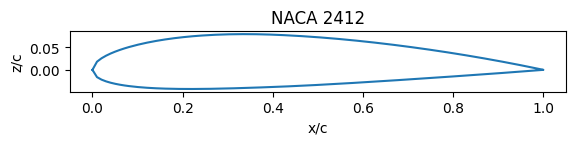

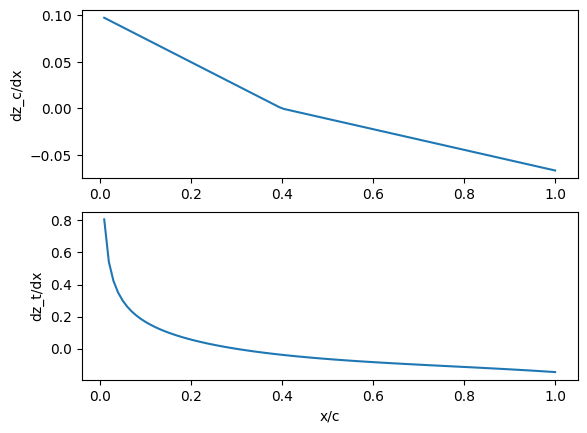

In [16]:
# Visualize a NACA 4-digit airfoil and the derivatives of its camber and
# thickness distributions
naca1 = '2412'
airfoil1 = NACA4digit(digits='2412')
visualizeAirfoil(airfoil1)

#### Objective 2 : To make a method class which can solve the flow given around a thin airfoil
Define Class : SolveThinAirfoil

It Takes  Airfoil Object as Argument
- Method: solve(AoA, toPlot=False)

-- Arugments :\
Angle of Attack , Flag to plot Cp vs X/c(default=False)

-- Result :\
Predicts Sectional Lift Coeff and Sectional Pitching Moment Coeff, Plots Cp vs X/c Graph

In [22]:
# defining class : SolveThinAirfoil

class SolveThinAirfoil(object):
    def __init__(self,thinAirfoil):
        self.thinAirfoil = thinAirfoil

    def solve(self,AoA,toPlot=False):
        AoA = AoA*np.pi/180
        # Solving Angle of Attack Problem

        cl_AoA = 2*np.pi*AoA    # finding 'cl' due to AoA using Thin Airfoil Theory

        cm_AoA = (0.4*cl_AoA) -(0.5*np.pi*AoA) # finding 'cm' due to AoA using Thin Airfoil Theory

        # Solving Camber Problem

        deltaX=1e-5
        
        x_by_c = np.linspace(deltaX,1-deltaX,100)

        try:
            # Finding coef when camber is not equal to zero
              
            y_cl = -4*self.thinAirfoil.dzc_dx(x_by_c,deltaX)*x_by_c/(np.sqrt(x_by_c-(x_by_c**2)))
            d_cl_Cmber = lambda x : np.interp(x, x_by_c,y_cl) # defining a function to integrate over 
            cl_Cmber = quad(d_cl_Cmber,0,1,limit=1000,points=x_by_c)  # Integrating to find 'cl' due to camber using Thin Airfoil Theory 

            y_cm = 2*self.thinAirfoil.dzc_dx(x_by_c,deltaX)*x_by_c/(np.sqrt(x_by_c-(x_by_c**2))) + 2*self.thinAirfoil.dzc_dx(x_by_c,deltaX)*np.sqrt(x_by_c-(x_by_c**2))
            d_cm_Cmber = lambda x : np.interp(x, x_by_c,y_cm)  # defining a function to integrate over 
            cm_Cmber = quad(d_cm_Cmber,0,1,limit=1000,points=x_by_c) # Integrating to find 'cm' due to camber using Thin Airfoil Theory 

        except ZeroDivisionError:
            # For symmetric when camber is zero, define both the coeff equal to zero 
            cl_Cmber = [0,]
            cm_Cmber = [0,]
        
        # Adding both the Coeff produced due to AoA problem and Camber problem using Thin Airfoil Theory
        cl = cl_AoA + cl_Cmber[0]
        cm = cm_AoA + cm_Cmber[0]

        # Solving Thickness Problem
        
        # Predicting Cp vs X/c curve when toPlot is set to True 
        if toPlot:
            x_by_c_flip = x_by_c[-1::-1]
            cpUP = np.zeros_like(x_by_c)
            cpLW = np.zeros_like(x_by_c_flip)
            for i in range(100):
                zeta = np.concatenate([x_by_c[:i],x_by_c[i+1:]]) # defining an array of variable 'zeta' 
                y_cp = np.concatenate([-2/np.pi*self.thinAirfoil.dzt_dx(x_by_c[:i],deltaX)/(x_by_c[i]-zeta[:i]),-2/np.pi*self.thinAirfoil.dzt_dx(x_by_c[i+1:],deltaX)/(x_by_c[i]-zeta[i:])])
                d_cp = lambda x : np.interp(x, zeta,y_cp) # defining a function to integrate over
                cpUP[i] = quad(d_cp,0,1,limit=1000,points=zeta)[0] # Integrating to find 'cpUP' using Thin Airfoil Theory

                zetal = np.concatenate([x_by_c_flip[:i],x_by_c_flip[i+1:]])
                y_cpL = np.concatenate([-2/np.pi*self.thinAirfoil.dzt_dx(x_by_c_flip[:i],deltaX)/(x_by_c_flip[i]-zetal[:i]),-2/np.pi*self.thinAirfoil.dzt_dx(x_by_c_flip[i+1:],deltaX)/(x_by_c_flip[i]-zetal[i:])])
                d_cpL = lambda x : np.interp(x, zetal,y_cpL)
                cpLW[i] = quad(d_cpL,0,1,limit=1000,points=zetal)[0] # Integrating to find 'cpUP' using Thin Airfoil Theory
            
            # Concatenating Upper Surface and Lower Surface Values
            X = np.concatenate([x_by_c,x_by_c_flip])
            CP = np.concatenate([cpUP,cpLW])
            
            # Plotting the Graph of Cp vs X/c 
            plt.plot(X,-CP,'o')
            plt.ylim(-8, 2)
            plt.title('-Cp vs x/c')
            plt.ylabel('-cp')
            plt.xlabel('x/c');
            return cl,cm,CP
        return cl,cm        
         

Sectional Lift Coefficient = 1.163853234954434 Sectional Pitching Moment Coefficient = -0.22745130218912066


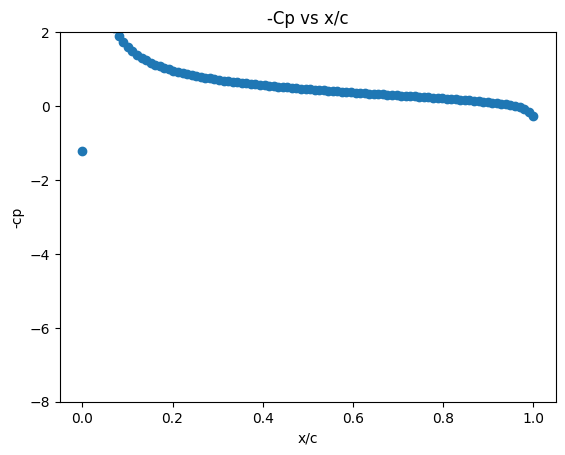

In [23]:
soln = SolveThinAirfoil(airfoil1)
cl,cm,cp =soln.solve(5,True);
print("Sectional Lift Coefficient =", cl, "Sectional Pitching Moment Coefficient =", cm)


Conclusion: 

We can use the above defined class and it's method to solve a given airfoil (of some NACAXXXX), which predicts the following:

- Sectional Lift Coeff at given Angle of Attack

- Sectional Pitching Moment Coeff 

- Cp vs X/c graph 

#### Objective 3 : 
Define Function : plotCoeffVsAoA(airfoil,AoA,toPlot)

-- Arugments :\
Airfoil Object, Range of Angle of Attack (default=np.linspace(-10,15,100)), Flag to plot Cp vs X/c(default=False)\
\
-- Result :\
Plots Cl vs AoA and Cm vs AoA Graph for a given Airfoil

In [11]:
def plotCoeffVsAoA(airfoil,AoA=np.linspace(-10,15,100),toPlot=False):

        soln = SolveThinAirfoil(airfoil) # using the above defined class method to solve the airfoil

        Cl = np.zeros_like(AoA)
        Cm = np.zeros_like(AoA)
        for i in range(len(AoA)):
            #Solving the above Airfoil for different AoA
            cl,cm= soln.solve(AoA[i])
            Cl[i] =cl
            Cm[i] =cm
        if toPlot:
            #Plotting Cl vs AoA obtained from solving the above Airfoil for different AoA
            fig,axes = plt.subplots(2,1, figsize=(13,10))
            axes[0].plot(AoA,Cl)
            axes[0].set_ylabel('Cl')
            axes[0].set_xlabel('AoA')
            axes[0].set_title('Cl vs AoA')
            axes[0].legend(['Thin Airfoil Sectional Lift Coeff',])
            #Plotting Cm vs AoA obtained from solving the above Airfoil for different AoA
            axes[1].plot(AoA,Cm)
            axes[1].set_ylabel('Cm')
            axes[1].set_title('Cm vs AoA')
            axes[1].legend(['Thin Airfoil Pitching Moment Coeff',])
            fig.suptitle('Coefficients vs Angle of Attack')
            plt.xlabel('AoA');
            
        return Cl,Cm
        

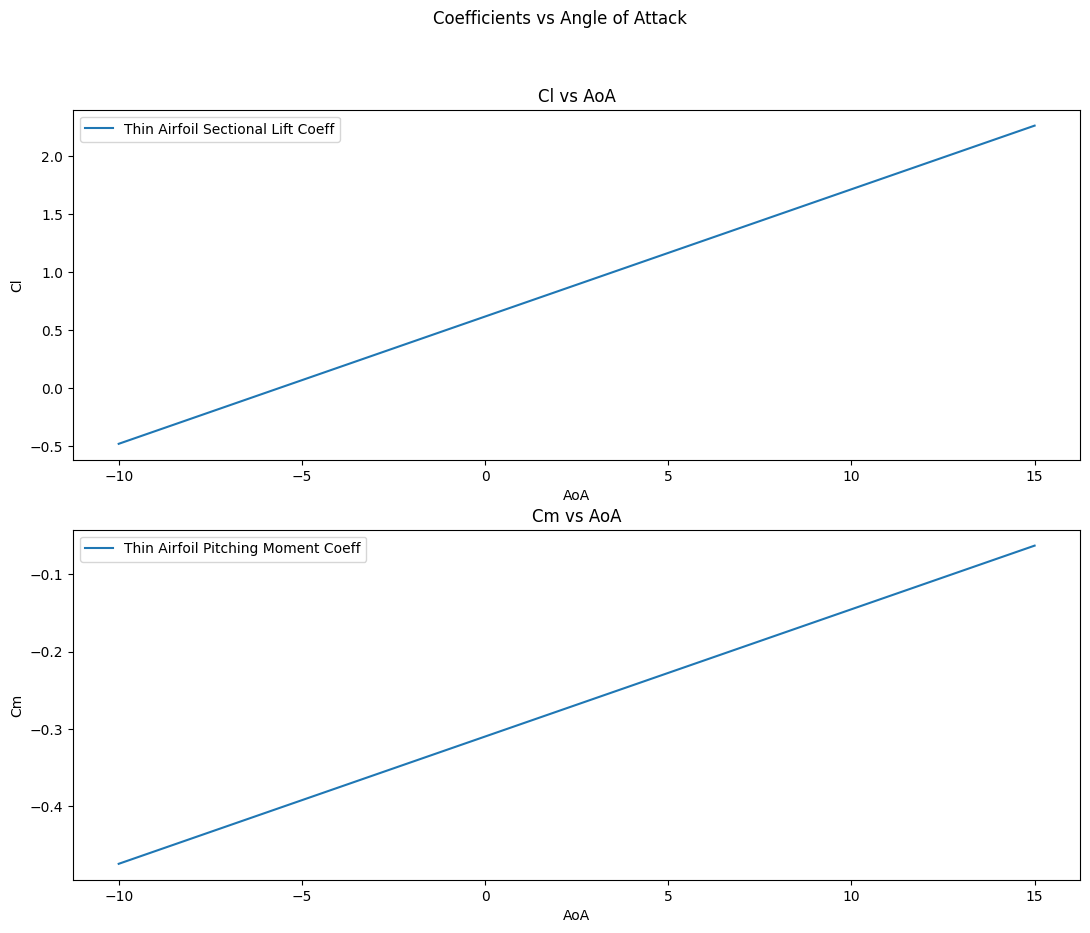

In [25]:
plotCoeffVsAoA(airfoil1,toPlot= True);

Conclusion: 

We can use the above fucntion to plots Cl vs AoA and Cm vs AoA Graph for a given Airfoil

#### Objective 4 : 

- Aim:\
Comparing the Predicted Results of NACA2408 vs Xfoil(inviscid) 

In [27]:
# Loading Data from Xfoil(inviscid) for NACA2408
NACA2408= np.loadtxt("Data/NACA2408.txt", dtype=float)
NACA2408P= np.loadtxt("Data/NACA2408P.txt", dtype=float)
XFOILP = pd.DataFrame(NACA2408P)
XFOIL = pd.DataFrame(NACA2408)

# defining an Airfoil Object for NACA2408
airfoil2 = NACA4digit(digits='2408')

Define Function : compareWithXFOIL(airfoil,XFOIL,XFOILP)

-- Arugments :\
Airfoil Object, Cp vs X/c data of XFOIL , Cl & Cm vs AoA data of XFOIL\
\
-- Result :
- Plots Cl vs AoA and Cm vs AoA Graph for a given Airfoil along with XFOIL, giving a visual representation of error in Cl and Cm values.
- Finds and Plots the Predicted AoA at Zero Lift  and Xfoil AoA at Zero Lift 

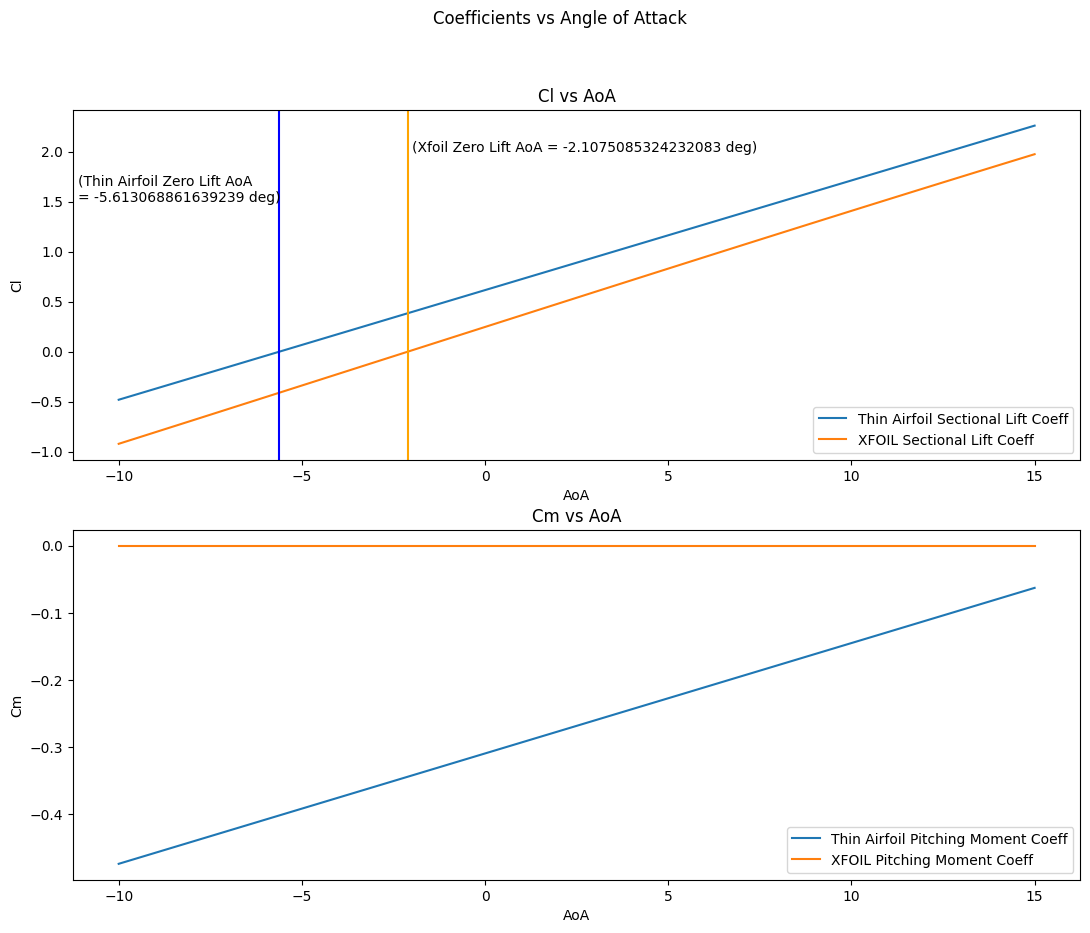

In [28]:
def compareWithXFOIL(airfoil,XFOIL,XFOILP):
    # taking out values from XFOIL dataframes
    XFOILx= XFOIL.iloc[:][0]
    XFOILz= XFOIL.iloc[:][1]
    XFOILcp= XFOIL.iloc[:][2]
    AoA = XFOILP.iloc[:][0]
    XFOILcl = XFOILP.iloc[:][1]
    XFOILcm = XFOILP.iloc[:][2]

    thinCl,thinCm = plotCoeffVsAoA(airfoil,AoA) # Predicting Cl and Cm for different AoA from earlier defined fucntion

    # Interpolating and finding out the AoA at zero lift by passing 'cl = 0' argument in interpolated function 
    f1 = lambda cl : np.interp(cl,thinCl,AoA)
    thinAoA0 = f1(0)
    f2 = lambda cl : np.interp(cl,XFOILcl,AoA)
    XFOILAoA0 = f2(0)

    # Plotting a Comparison of Prdicted and Xfoil Coeff Values
    fig,axes = plt.subplots(2,1, figsize=(13,10))
    axes[0].plot(AoA,thinCl)
    axes[0].plot(AoA,XFOILcl)
    axes[0].axvline(thinAoA0, color = 'b')
    axes[0].annotate(f"(Thin Airfoil Zero Lift AoA \n= {thinAoA0} deg)", xy=(thinAoA0-5.5,1.5))
    axes[0].annotate(f"(Xfoil Zero Lift AoA = {XFOILAoA0} deg)", xy=(XFOILAoA0+0.1,2))
    axes[0].axvline(XFOILAoA0, color = 'orange')
    axes[0].set_ylabel('Cl')
    axes[0].set_xlabel('AoA')
    axes[0].set_title('Cl vs AoA')
    axes[0].legend(['Thin Airfoil Sectional Lift Coeff','XFOIL Sectional Lift Coeff'])
    axes[1].plot(AoA,thinCm)
    axes[1].plot(AoA,XFOILcm)
    axes[1].set_ylabel('Cm')
    axes[1].set_title('Cm vs AoA')
    axes[1].legend(['Thin Airfoil Pitching Moment Coeff','XFOIL Pitching Moment Coeff'])
    fig.suptitle('Coefficients vs Angle of Attack')
    plt.xlabel('AoA');

    
compareWithXFOIL(airfoil2,XFOIL,XFOILP)

Solving the NACA2408 Airfoil at AoA = 8 deg, by previously defined class method and ploting Predicted Cp vs X/c Graph along with Xfoil Cp vs X/c, which gives us a good visual representation of our error in predicting the pressure coeff at AoA = 8 deg

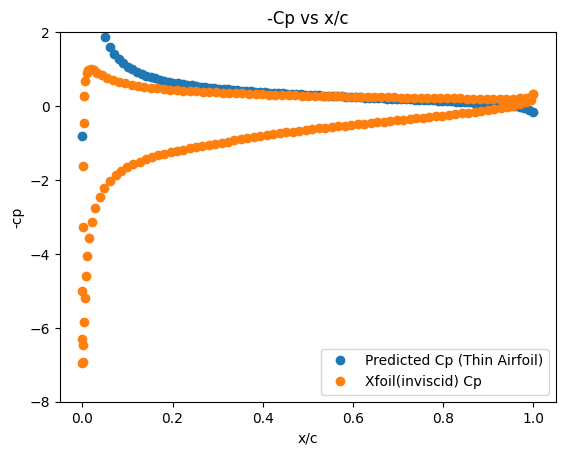

In [30]:
soln = SolveThinAirfoil(airfoil2)
cl,cm,cp= soln.solve(8,True)
XFOILx= XFOIL.iloc[:][0]
XFOILcp= XFOIL.iloc[:][2]
plt.plot(XFOILx,XFOILcp,'o');
plt.legend(['Predicted Cp (Thin Airfoil)','Xfoil(inviscid) Cp']);

#### Conslusion :

The Predicted values of Aerodynamics Coefficents from Thin Airfoil are very close to Xfoil(inviscid) values, hence we can say this theory is quite solid to solve flow around an airfoil.

The Theory does produces errors and deviates due to the following assumptions that we undertook: 
- AoA is very low 
- Thickness is very less hence thin airfoils
- Low Speeds 

Hence, the Theory produces greater error as the Angle of Attack and Thickness of the Airfoil increases, but we can use it very effectively for low angle of attacks and thinner airfoils.